In [546]:
# K = 4, 5, 6, 7, 8에 대하여 돌린다.
# 산출되는 결과는 results 폴더에 저장된다.
# 공통적으로 얻어지는 파일은 3개이다.
# 각 K마다 얻어지는 파일은 각 6개이다.
# 따라서 3+5*6=33개의 파일이 얻어진다.
K = 8

In [547]:
import numpy as np
import pandas as pd
import dataframe_image as dfi

import folium

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

# 속성 선택 (feature selection)

## 데이터 불러오기 및 병합

In [548]:
collected_data = pd.read_csv('../../data/data_d_final/2d201_1230_collected_data.csv')
collected_data.set_index("지역", inplace=True)
collected_data.head()

,위도,경도,쏘카존 수,녹지,주거,공업,상업,인구,대학교 수,아파트 수,지하철역 수,정류장 수,환승역 수,행복주택 수
지역,,,,,,,,,,,,,,
수원시 장안구,37.303971,127.001743,18,0.272727,0.727273,0.000000,0.000000,271012,4,200,1,409,0,0
수원시 권선구,37.257687,126.963532,16,0.625000,0.312500,0.062500,0.000000,367004,1,159,4,537,0,1
수원시 팔달구,37.282570,127.011718,20,0.136364,0.409091,0.000000,0.454545,192225,0,65,4,185,2,1
수원시 영통구,37.259600,127.042341,34,0.142857,0.571429,0.285714,0.000000,360127,21,129,6,380,0,3
용인시 처인구,37.234346,127.192965,29,0.823529,0.058824,0.000000,0.117647,259872,15,112,9,1234,0,1


In [549]:
hackathon_data_original = pd.read_csv("../../data/20211022_수요예측_hackathon_data.csv", encoding='cp949')
hackathon_data_original.head()

,region1,region2,reservation_return_at,reservation_start_at,age_group,gender,car_model
0,울산광역시,남구,2019-09-29 21:25:40+00:00,2019-09-29 19:20:00+00:00,1,male,경형
1,울산광역시,남구,2019-07-13 13:11:21+00:00,2019-07-13 11:00:00+00:00,1,male,준중형
2,울산광역시,남구,2019-09-16 23:43:08+00:00,2019-09-16 19:10:00+00:00,1,male,준중형
3,울산광역시,남구,2019-08-09 06:17:41+00:00,2019-08-09 00:20:00+00:00,1,male,준중형
4,울산광역시,남구,2019-07-24 12:36:29+00:00,2019-07-24 09:00:00+00:00,2,male,경형


In [550]:
hackathon_data = pd.DataFrame(hackathon_data_original['region2'].value_counts())
hackathon_data.columns = ['이용 수']
hackathon_data

,이용 수
성남시 분당구,46782
화성시,35249
고양시 일산동구,31906
남양주시,26546
고양시 덕양구,26253
의정부시,25225
안양시 동안구,22918
광명시,22645
남구,21836
김포시,21500


In [551]:
intersected_rows = set.intersection(set(collected_data.index), set(hackathon_data.index))
intersected_rows = list(intersected_rows)
print(intersected_rows, len(intersected_rows))

['양평군', '광명시', '하남시', '의정부시', '남양주시', '구리시', '화성시', '김포시'] 8


In [552]:
collected_data_intersected = collected_data[collected_data.index.isin(intersected_rows)]
collected_data_intersected.sort_index(ascending=True, inplace=True)
hackathon_data_intersected = hackathon_data[hackathon_data.index.isin(intersected_rows)]
hackathon_data_intersected.sort_index(ascending=True, inplace=True)
intersected = pd.concat([collected_data_intersected, hackathon_data_intersected],axis=1)
intersected['쏘카존 수 대비 이용 수'] = intersected['이용 수']/intersected['쏘카존 수']
intersected

,위도,경도,쏘카존 수,녹지,주거,공업,상업,인구,대학교 수,아파트 수,지하철역 수,정류장 수,환승역 수,행복주택 수,이용 수,쏘카존 수 대비 이용 수
광명시,37.478618,126.856271,28,0.222222,0.666667,0.000000,0.111111,288182,0,89,3,445,0,0,22645,808.750000
구리시,37.594266,127.121253,19,0.500000,0.500000,0.000000,0.000000,188876,0,111,2,313,0,1,13011,684.789474
김포시,37.615350,126.707165,55,0.400000,0.533333,0.066667,0.000000,484194,3,229,9,1325,0,7,21500,390.909091
남양주시,37.635985,127.212283,57,0.526316,0.473684,0.000000,0.000000,737366,2,385,13,1803,0,6,26546,465.719298
양평군,37.491791,127.479218,5,1.000000,0.000000,0.000000,0.000000,122463,7,39,9,1051,0,1,2987,597.400000
의정부시,37.738083,127.025374,37,0.461538,0.461538,0.000000,0.076923,463789,6,299,21,716,0,5,25225,681.756757
하남시,37.539301,127.206495,29,0.458333,0.541667,0.000000,0.000000,325310,0,131,4,581,0,6,13456,464.000000
화성시,37.199565,126.823026,56,0.567568,0.351351,0.054054,0.027027,907958,27,388,3,2873,2,17,35249,629.446429


## 상관관계 분석 (pearson correlation analysis)

In [553]:
pearson_original = intersected.corr()
pearson = pearson_original[['이용 수', '쏘카존 수 대비 이용 수']]
pearson.drop(index = ['이용 수', '쏘카존 수 대비 이용 수'], inplace=True)
pearson

,이용 수,쏘카존 수 대비 이용 수
위도,-0.281031,-0.195644
경도,-0.703295,-0.061641
쏘카존 수,0.860369,-0.437145
녹지,-0.526912,-0.165893
주거,0.441748,0.076315
공업,0.466754,-0.404513
상업,0.360662,0.758230
인구,0.892522,-0.264118
대학교 수,0.536120,0.090625
아파트 수,0.857225,-0.279650


In [554]:
dfi.export(pearson,'results/1b_201_0112_pearson.png', max_cols=-1, max_rows=-1)

In [555]:
pearson[pearson.abs() > 0.3]

,이용 수,쏘카존 수 대비 이용 수
위도,NaN,NaN
경도,-0.703295,NaN
쏘카존 수,0.860369,-0.437145
녹지,-0.526912,NaN
주거,0.441748,NaN
공업,0.466754,-0.404513
상업,0.360662,0.758230
인구,0.892522,NaN
대학교 수,0.536120,NaN
아파트 수,0.857225,NaN


# 군집화

## 군집화 (k-Means Clustering, elbow method)

In [556]:
collected_data.head()

,위도,경도,쏘카존 수,녹지,주거,공업,상업,인구,대학교 수,아파트 수,지하철역 수,정류장 수,환승역 수,행복주택 수
지역,,,,,,,,,,,,,,
수원시 장안구,37.303971,127.001743,18,0.272727,0.727273,0.000000,0.000000,271012,4,200,1,409,0,0
수원시 권선구,37.257687,126.963532,16,0.625000,0.312500,0.062500,0.000000,367004,1,159,4,537,0,1
수원시 팔달구,37.282570,127.011718,20,0.136364,0.409091,0.000000,0.454545,192225,0,65,4,185,2,1
수원시 영통구,37.259600,127.042341,34,0.142857,0.571429,0.285714,0.000000,360127,21,129,6,380,0,3
용인시 처인구,37.234346,127.192965,29,0.823529,0.058824,0.000000,0.117647,259872,15,112,9,1234,0,1


In [557]:
# X : clustering에 사용할 data(dataframe), 상관관계 분석을 통해 '위도'와 '지하철역 수'를 feature 목록에서 제거
X = collected_data.copy()
# y : clustering의 결과를 기록할 dataframe
y = pd.DataFrame(index = collected_data.index)
X.drop(columns = ['위도', '지하철역 수'], inplace=True)
X.shape

(42, 12)

In [558]:
distortions = []

for k in range(1,20):
    kmean = KMeans(n_clusters=k, random_state=0, n_init=50, max_iter=500)
    # centroid들의 intialization이 50종류이다.
    # 각 종류의 initialization에 대하여 iteration을 최대 500번 진행한다. (500번보다 적은 iteration동안 centroid가 더이상 움직이지 않으면, 거기서 멈춘다.)
    # 사실 두 값을 적게 잡아도 큰 차이가 나지는 않지만, 학습과정에 큰 시간이 들지 않으므로 넉넉하게 50, 500으로 잡았다.
    kmean.fit(X)
    distortions.append(kmean.inertia_)

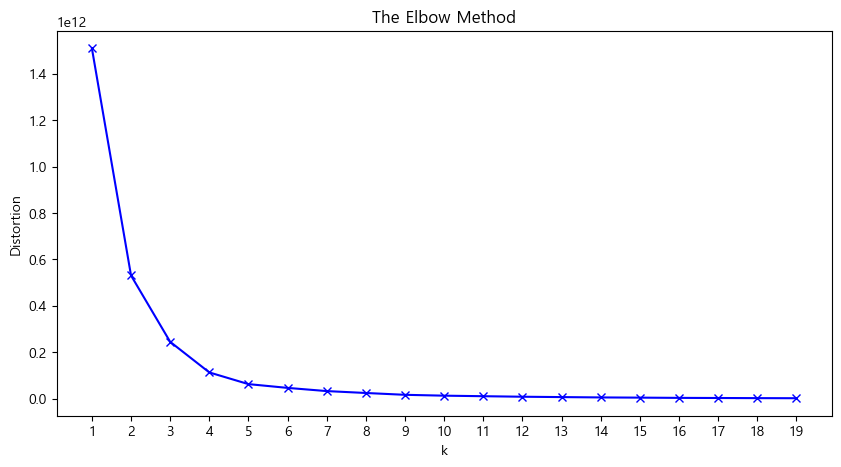

In [559]:
plt.figure(figsize=(10,5))
plt.plot(range(1,20), distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.xticks(range(1,20))
plt.title('The Elbow Method')
plt.savefig('results/1b_202_0112_elbow.png.png')
plt.show()

## 군집화 결과

In [560]:
# K = 4, 5, 6, 7, 8
# K를 정하는 코드를 맨 위의 셀에 두었다.

In [561]:
kmeans = KMeans(n_clusters=K, random_state=0).fit(X)
y['군집'] = kmeans.labels_
for k in range(K):
    print('cluster ', k, ' : ', y.index[y['군집'] == k].tolist())

cluster  0  :  ['용인시 기흥구', '성남시 분당구', '시흥시', '김포시', '고양시 덕양구', '파주시', '의정부시']
cluster  1  :  ['수원시 팔달구', '성남시 수정구', '성남시 중원구', '안양시 만안구', '오산시', '이천시', '안성시', '의왕시', '양주시', '구리시']
cluster  2  :  ['부천시', '남양주시']
cluster  3  :  ['양평군', '여주시', '과천시', '포천시', '동두천시', '가평군', '연천군']
cluster  4  :  ['수원시 장안구', '용인시 처인구', '안산시 단원구', '안양시 동안구', '광명시', '군포시', '고양시 일산동구', '고양시 일산서구']
cluster  5  :  ['수원시 권선구', '수원시 영통구', '용인시 수지구', '안산시 상록구', '광주시', '하남시']
cluster  6  :  ['화성시']
cluster  7  :  ['평택시']


## 군집화 결과 분석

In [562]:
collected_data_clustered = pd.concat([collected_data, y], axis = 1)
collected_data_clustered.head()

,위도,경도,쏘카존 수,녹지,주거,공업,상업,인구,대학교 수,아파트 수,지하철역 수,정류장 수,환승역 수,행복주택 수,군집
지역,,,,,,,,,,,,,,,
수원시 장안구,37.303971,127.001743,18,0.272727,0.727273,0.000000,0.000000,271012,4,200,1,409,0,0,4
수원시 권선구,37.257687,126.963532,16,0.625000,0.312500,0.062500,0.000000,367004,1,159,4,537,0,1,5
수원시 팔달구,37.282570,127.011718,20,0.136364,0.409091,0.000000,0.454545,192225,0,65,4,185,2,1,1
수원시 영통구,37.259600,127.042341,34,0.142857,0.571429,0.285714,0.000000,360127,21,129,6,380,0,3,5
용인시 처인구,37.234346,127.192965,29,0.823529,0.058824,0.000000,0.117647,259872,15,112,9,1234,0,1,4


In [563]:
collected_data_clustered.to_csv("../../data/data_d_final/2d201_0112_collected_data_clustered_"+"K="+str(K)+".csv")
dfi.export(collected_data_clustered, "results/1b_203_0112_collected_data_clustered"+"K="+str(K)+".png")

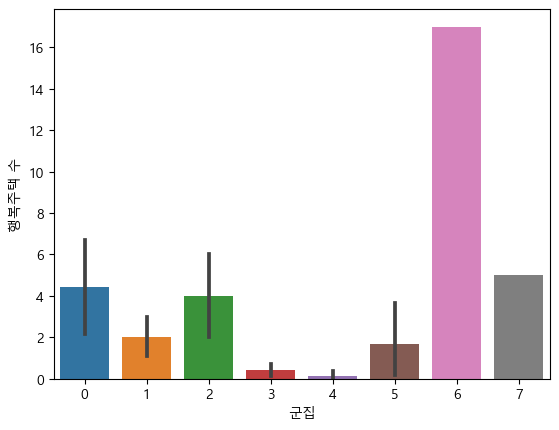

In [564]:
plt.rcParams['font.family'] = 'Malgun Gothic'
sns.barplot(x="군집", y="행복주택 수", data=collected_data_clustered)#, ci=None)
plt.savefig("results/1b_204_0112_cluster_result_happyhouse"+"K="+str(K)+".png")
plt.show()

In [565]:
# 다른 feature들과 군집화 사이의 관계
collected_data_clustered.groupby('군집').mean()
dfi.export(collected_data_clustered.groupby('군집').mean(), "results/1b_205_0112_features_by_clusters"+"K="+str(K)+".png")

In [566]:
intersected_ = intersected.copy()

In [567]:
intersected_['군집'] = intersected_.index.map(dict(zip(collected_data_clustered.index, collected_data_clustered['군집'])))
pearson_original_ = intersected_.corr()
pearson_ = pearson_original_[['군집']]
pearson_.drop(index = ['군집'], inplace=True)
dfi.export(pearson_, "results/1b_206_0112_pearson_analysis_wrt_clusters"+"K="+str(K)+".png")
pearson_

,군집
위도,-0.836284
경도,0.061814
쏘카존 수,-0.032138
녹지,0.080254
주거,-0.105036
공업,0.016665
상업,0.061109
인구,0.239137
대학교 수,0.480017
아파트 수,-0.022819


# 군집에 대한 시각화

## PCA를 통한 시각화

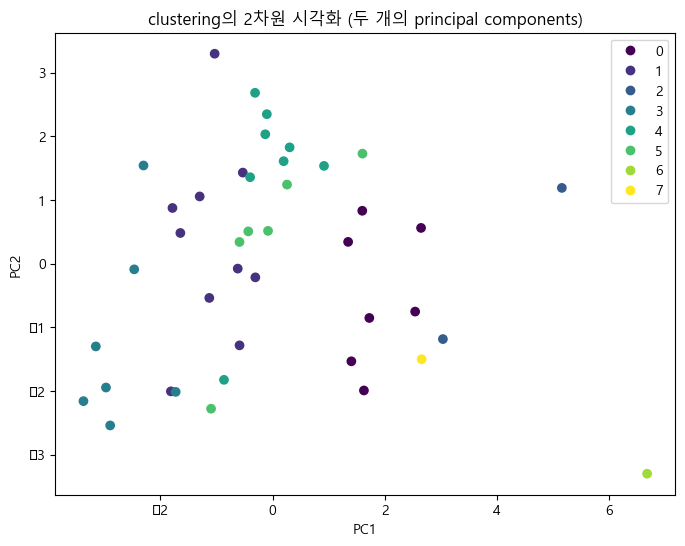

In [568]:
# X에 대하여 standardization 및 PCA를 적용한다. PCA에 간략한 설명은 다음과 같다.
# X는 42개의 14차원의 벡터이다. 이 42개의 벡터들은 서로 직교하지 않은 상태이다.
# 이것을 새로운 42개의 14차원 벡터들로 변환하여 Xt를 만들되, 각각의 벡터들이 서로 직교하도록,
# 그리고 각각의 벡터들이 중요한 의미를 가지도록 변환하는 것이다.
# (조금 더 정확하게는, X와 X transpose의 곱인 square symmetric matrix N에 대하여
# Xt의 42개의 벡터들은 N의 eigenvector가 되고, 그에 대응되는 eigenvalue들은 절댓값이 큰 순으로 정렬되어 있다.)
# Xt의 첫 벡터 PC1(the first principal component)는 X를 projection했을 때, 가장 많은 정보가 보존되는 벡터이다.
# Xt의 두번째 벡터 PC2는 PC1과 직교하는 벡터이면서 X를 projection했을 때, 가장 많은 정보가 보존되는 벡터이다.
# 즉, PC1과 PC2의 방향은, 원래 데이터 X의 정보를 가장 잘 보존시키는 두 개의 벡터이다.
# 이 두 개의 방향에 대한 두 개의 성분들을 고려하면
# 14차원의 정보를 2차원의 정보로 효율적으로 축소시킨 셈이다(dimensionality reduction).
# 이번 코드에서는 이러한 차원축소를 통해, clustering을 시각화하는 데에 사용했다.
# standardization은 이러한 PCA가 더 잘 작용되도록 해준다. 하지만, 이번 경우에는 standardization을 적용하지 않아도 결과가 잘 나타나기는 한다.

pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA())])
plt.figure(figsize=(8,6))
Xt = pipe.fit_transform(X)
plot = plt.scatter(Xt[:,0], Xt[:,1], c=y['군집'])
plt.legend(handles=plot.legend_elements()[0], labels=list(range(K)))
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("clustering의 2차원 시각화 (두 개의 principal components)")
plt.savefig("results/1b_207_0112_2d_visualization"+"K="+str(K)+".png")
plt.show()

## `folium`을 이용한 시각화 (1)

### 쏘카존 수 시각화

In [569]:
# 서울의 위도와 경도
latitude = 37.532600
longitude = 127.024612

map_zone = folium.Map(location=[latitude, longitude], zoom_start=9)

In [570]:
cities = collected_data.reset_index()[['지역', '위도', '경도', '쏘카존 수']]
cities.head()

,지역,위도,경도,쏘카존 수
0,수원시 장안구,37.303971,127.001743,18
1,수원시 권선구,37.257687,126.963532,16
2,수원시 팔달구,37.282570,127.011718,20
3,수원시 영통구,37.259600,127.042341,34
4,용인시 처인구,37.234346,127.192965,29


In [571]:
zcounts = folium.map.FeatureGroup()
n_mean = collected_data['쏘카존 수'].mean()

for region, lat, lng, zcount in zip(collected_data.index,
                            collected_data['위도'],
                            collected_data['경도'],
                            collected_data['쏘카존 수']):
    zcounts.add_child(
        folium.vector_layers.CircleMarker(
            [lat, lng],
            radius=zcount/n_mean*5, # define how big you want the circle markers to be
            fill=True,
            fill_color='blue',
            fill_opacity=0.6,
            tooltip = str(region) + ', ' + str(zcount) + '개의 쏘카존'
        )
    )

map_zone.add_child(zcounts)

In [572]:
map_zone.save("results/1b_208_0112_map_zone.html")

### 군집화에 대한 시각화

In [573]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=9)

# set color scheme for the clusters
x = np.arange(K)
ys = [i + x + (i*x)**2 for i in range(K)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lng, region, cluster in zip(collected_data['위도'], collected_data['경도'], collected_data.index, y['군집']):
    #label = folium.Popup(str(city)+ ','+str(state) + '- Cluster ' + str(cluster), parse_html=True)
    folium.vector_layers.CircleMarker(
        [lat, lng],
        radius=5,
        #popup=label,
        tooltip = str(region) + '- Cluster ' + str(cluster),
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(map_clusters)
       
map_clusters

In [574]:
map_clusters.save("results/1b_209_0112_map_clusters.png"+"K="+str(K)+".html")

## `folium`을 이용한 시각화 (2)

In [575]:
# #1. package load
# import requests
# import json
# import os
# import math
# import time
# import pandas as pd
# import numpy as np
# import geopandas as gpd
# import folium
# import matplotlib.pyplot as plt

# from shapely.geometry import mapping, shape, Point, Polygon, LineString
# from folium import plugins
# from folium.plugins import MarkerCluster, HeatMap
# print('슝~')

In [576]:
# #7 서울시 구별 인구수 데이터 수집 및 시각화  .. 데이터 수집 및 전처리 .. 구단위 data
# k_geo_data_path = '../0112_main/data/data_b_raw/2b303_0112_kyungki_region.json'
# k_geo_data = json.load(
#     open(k_geo_data_path, encoding="utf-8")
# )

# print('슝~')

In [577]:
# collected_data_clustered

In [578]:
# #7 서울시 구별 인구수 데이터 수집 및 시각화  .... map center 지정
# # 서울시 중심부 위도, 경도
# center = [37.541, 126.986]

# # map이 서울 중심부에 위치하고, zoom 레벨은 10으로 시작 합니다.
# map = folium.Map(
#     location=center,
#     zoom_start=10,
#     )

# print('슝~')

In [579]:
# collected_data_clustered['쏘카존 수'] = collected_data_clustered['쏘카존 수'].astype(str)

In [580]:
# #7 서울시 구별 인구수 데이터 수집 및 시각화 ..  data add
# folium.Choropleth(
#     geo_data=k_geo_data,
#     name="경기도 군집화",
#     data=collected_data_clustered,
#     columns=["쏘카존 수", "군집"],
#     key_on="feature.properties.ADM_SECT_C",
#     fill_color='YlOrRd',
#     fill_opacity=0.7,
#     line_opacity=0.2,
#     line_color='white', 
#     nan_fill_color='blue',
#     line_weight=0,
#     highlight=False, 
#     smooth_factor=1.0,
#     legend_name="군집"
# ).add_to(map)

In [581]:
# map
